<a href="https://colab.research.google.com/github/yoniv1/C3S2_templates/blob/main/Geodetic_MB_Svalbard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install dependencies
!pip install rasterio==1.4 geopandas==1.0.1 shapely==2.1.0
!pip install -U xdem
!pip install scikit-gstat

  Using cached rasterio-1.4.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.0 kB)
Using cached rasterio-1.4.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (22.2 MB)
  Attempting uninstall: rasterio
    Found existing installation: rasterio 1.4.3
    Uninstalling rasterio-1.4.3:
      Successfully uninstalled rasterio-1.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rioxarray 0.20.0 requires rasterio>=1.4.3, but you have rasterio 1.4.0 which is incompatible.
  Using cached rasterio-1.4.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
Using cached rasterio-1.4.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (22.3 MB)
  Attempting uninstall: rasterio
    Found existing installation: rasterio 1.4.0
    Uninstalling rasterio-1.4.0:
      Successfully uninstalled rasterio-1.4.0
   

In [13]:
# Verify
import xdem
print(xdem.__version__)

0.2.0


In [14]:
import matplotlib.pyplot as plt
import geoutils as gu
import numpy as np

# Open two DEMs
ref_dem = xdem.DEM("geodetic_mb_svalbard/Reprojected_DEM_1990.tif")
tba_dem = xdem.DEM("geodetic_mb_svalbard/Reprojected_DEM_1936.tif")

# Open glacier outlines as vector
glacier_outlines = gu.Vector("geodetic_mb_svalbard/Glacier_Outline_1936.shp")

# Create a stable ground mask (not glacierized) to mark "inlier data"
inlier_mask = ~glacier_outlines.create_mask(ref_dem)

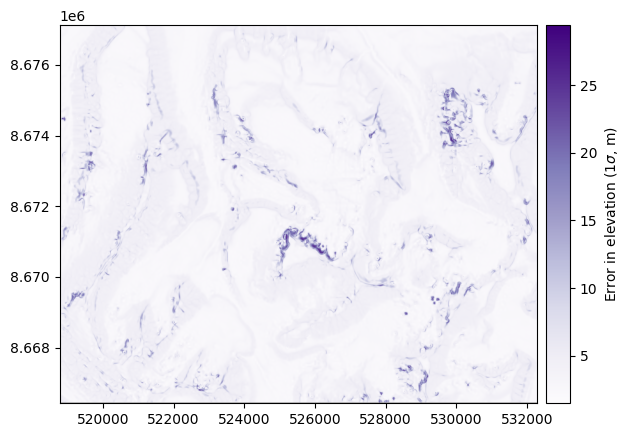

In [15]:
# Estimate elevation uncertainty assuming both DEMs have similar precision
sig_dem, rho_sig = tba_dem.estimate_uncertainty(ref_dem, stable_terrain=inlier_mask, precision_of_other="same", random_state=42)

# The error map variability is estimated from slope and curvature by default
sig_dem.plot(cmap="Purples", cbar_title=r"Error in elevation (1$\sigma$, m)")

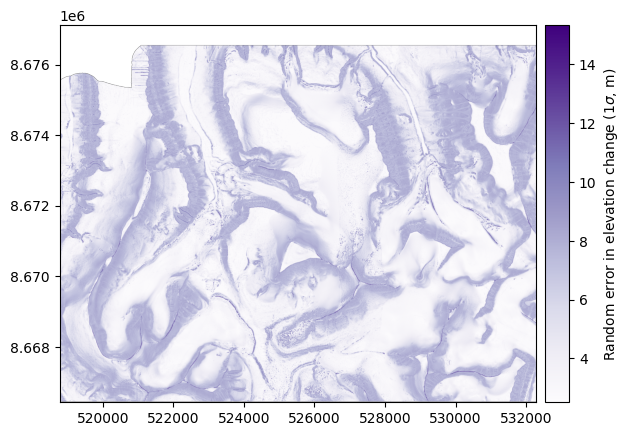

In [16]:
# Get elevation differences and stable terrain mask
dh = ref_dem - tba_dem
stable_terrain = ~glacier_outlines.create_mask(dh)

# Derive slope and curvature
slope, curv = ref_dem.get_terrain_attribute(attribute=["slope", "curvature"])

# Use only array of stable terrain
dh_arr = dh[stable_terrain]
slope_arr = slope[stable_terrain]
curv_arr = curv[stable_terrain]

# Estimate the variable error by bin of slope and curvature
df_h = xdem.spatialstats.nd_binning(
    dh_arr, list_var=[slope_arr, curv_arr], list_var_names=["slope", "curv"], statistics=["count", gu.stats.nmad], list_var_bins=[np.linspace(0, 60, 10), np.linspace(-10, 10, 10)]
)

# Derive a numerical function of the measurement error
sig_dh_func = xdem.spatialstats.interp_nd_binning(df_h, list_var_names=["slope", "curv"])

# Apply function to the slope and curvature on all terrain
sig_dh_arr = sig_dh_func((slope.data, curv.data))

# Convert to raster and plot
sig_dh = dh.copy(new_array=sig_dh_arr)
sig_dh.plot(cmap="Purples", cbar_title=r"Random error in elevation change (1$\sigma$, m)")


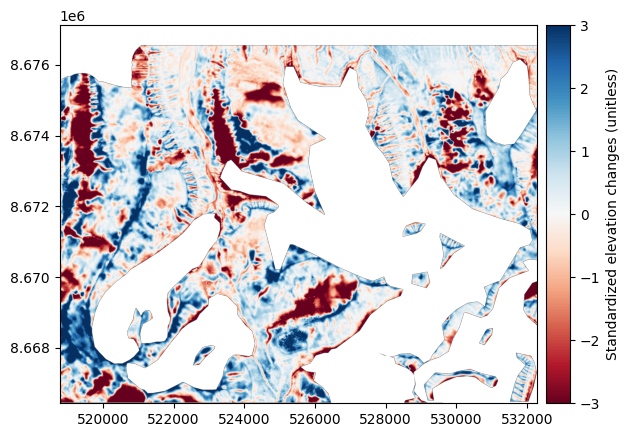

In [17]:
# Standardize the data
z_dh = dh / sig_dh
# Mask values to keep only stable terrain
z_dh.set_mask(~stable_terrain)
# Plot the standardized data on stable terrain
z_dh.plot(cmap="RdBu", vmin=-3, vmax=3, cbar_title="Standardized elevation changes (unitless)")


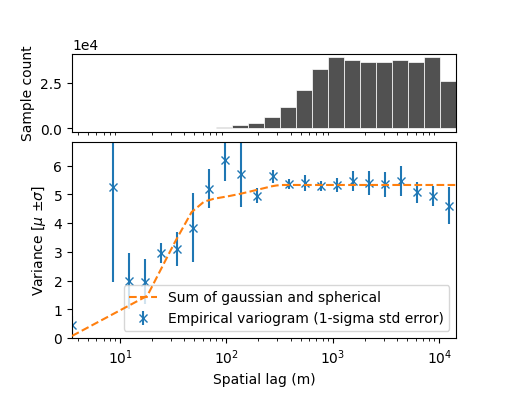

In [18]:
# Sample empirical variogram
df_vgm = xdem.spatialstats.sample_empirical_variogram(values=z_dh, subsample=500, n_variograms=5, random_state=42)

# Fit the sum of a gaussian and spherical model
func_sum_vgm, params_variogram_model = xdem.spatialstats.fit_sum_model_variogram(
    list_models=["Gaussian", "Spherical"], empirical_variogram=df_vgm
)
# Plot empirical and modelled variogram
xdem.spatialstats.plot_variogram(df_vgm, [func_sum_vgm], ["Sum of gaussian and spherical"], xscale="log")


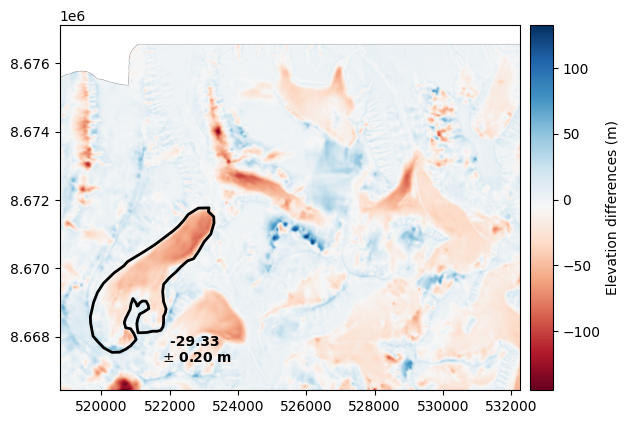

In [19]:
# Get an area of interest where we want to propagate errors
outline_scott = gu.Vector(glacier_outlines.ds[glacier_outlines.ds["id"] == 1])
mask_scott = outline_scott.create_mask(dh)
# Calculate the mean random error in the area
mean_sig = np.nanmean(sig_dh[mask_scott])
# Calculate the area-averaged uncertainty with these models
neff = xdem.spatialstats.number_effective_samples(area=outline_scott, params_variogram_model=params_variogram_model)
# Compute the standard error
sig_dh_scott = mean_sig / np.sqrt(neff)

# Mean elevation difference
dh_scott = np.nanmean(dh[mask_scott])

# Plot the result
dh.plot(cmap="RdBu", cbar_title="Elevation differences (m)")
outline_scott.plot(dh, fc="none", ec="black", lw=2)
plt.text(
    outline_scott.ds.centroid.x.values[0] + 1500,
    outline_scott.ds.centroid.y.values[0] - 1500,
    f"{dh_scott:.2f} \n$\\pm$ {sig_dh_scott:.2f} m",
    color="black",
    fontweight="bold",
    va="top",
    ha="center",
)
plt.show()
